# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import time
import torch

from agent import DDPGAgent
from collections import deque
from unityagents import UnityEnvironment

%matplotlib inline

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

When finished, you can close the environment.

### 3. Train DDPG!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [2]:
def train_ddpg(env, agent, config):
    '''Runs the training loop'''
    nepisodes = config['nepisodes']
    ntimesteps = config['nsteps']
    target_score = config['target_score']

    average_over_episodes = config['average_over_episodes']

    actor_weights_path = config['actor_weights_path']
    critic_weights_path = config['critic_weights_path']

    brain_name = config['brain_name']
    num_agents = config['number_agents']

    mean_scores = []                               # list of mean scores from each episode
    min_scores = []                                # list of lowest scores from each episode
    max_scores = []                                # list of highest scores from each episode
    best_score = -np.inf
    scores_window = deque(maxlen=average_over_episodes)  # mean scores from most recent episodes
    moving_avgs = []                               # list of moving averages
    
    for i_episode in range(1, nepisodes + 1):

        env_info = env.reset(train_mode=True)[brain_name] # reset environment
        states = env_info.vector_observations                   # get current state for each agent
        scores = np.zeros(num_agents)                           # initialize score for each agent

        agent.reset()

        start_time = time.time()

        for t in range(ntimesteps):
            actions = agent.act(states)                         # select an action

            env_info = env.step(actions)[brain_name]            # send actions to environment
            next_states = env_info.vector_observations          # get next state
            rewards = env_info.rewards                          # get reward
            dones = env_info.local_done                         # see if episode has finished

            # Log into replay memory
            agent.remember(states, actions, rewards, next_states, dones)
            agent.step(t)

            states = next_states
            scores += rewards

            if np.any(dones):                                   # exit loop when episode ends
                break

        duration = time.time() - start_time

        min_scores.append(np.min(scores))             # save lowest score for a single agent
        max_scores.append(np.max(scores))             # save highest score for a single agent

        mean_scores.append(np.mean(scores))           # save mean score for the episode

        scores_window.append(mean_scores[-1])         # save mean score to window

        moving_avgs.append(np.mean(scores_window))    # save moving average

        print('\rEpisode {} ({} sec)  -- \tMin reward: {:.1f}\tMax reward: {:.1f}\tMean reward: {:.1f}\tMoving Average: {:.1f}'.format(
            i_episode,
            round(duration),
            min_scores[-1],
            max_scores[-1],
            mean_scores[-1],
            moving_avgs[-1])
        )
        
        if mean_scores[-1] > best_score:
            # Note: Save every progress we make
            torch.save(agent.learnt_actor.state_dict(), actor_weights_path)
            torch.save(agent.learnt_critic.state_dict(), critic_weights_path)

        if moving_avgs[-1] >= target_score and i_episode >= average_over_episodes:
            print('\nEnvironment was solved in {} episodes!\tMoving Average ={:.1f} over last {} episodes'.format(
                i_episode - average_over_episodes, 
                moving_avgs[-1], 
                average_over_episodes
            ))

            torch.save(agent.learnt_actor.state_dict(), actor_weights_path)
            torch.save(agent.learnt_critic.state_dict(), critic_weights_path)  
            break

    return mean_scores, moving_avgs

In [3]:
print('Launching environment!')

env = UnityEnvironment(file_name='Reacher_Windows_x86_64_many/Reacher.exe')
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

env_info = env.reset(train_mode=True)[brain_name]
    
action_size = brain.vector_action_space_size

states = env_info.vector_observations
state_size = states.shape[1]

# Note: Could be extended to a cli (argparse)
agent_config = {
    'seed': 1,
    'batch_size': 128,
    'memory_size': int(1e5),
    'gamma': 0.99,
    'tau': 1e-3,
    'actor_lr': 1e-3,
    'critic_lr': 1e-3,
    'update_every': 20,
    'update_iterations': 10,
    'noise_decay': 0.999,
    'number_agents': len(env_info.agents)
}

agent = DDPGAgent(state_size, action_size, agent_config)

root_path = 'weights'
training_config = {
    'nepisodes': 500,
    'nsteps': 1000,
    'average_over_episodes': 100,
    'target_score': 30,
    'brain_name': brain_name,
    'number_agents': len(env_info.agents),
    'actor_weights_path': os.path.join(root_path, 'actor_weights_checkpoint.pth'),
    'critic_weights_path': os.path.join(root_path, 'critic_weights_checkpoint.pth')
}

trajectory_scores, moving_average_scores = train_ddpg(env, agent, training_config)

Launching environment!


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_speed -> 1.0
		goal_size -> 5.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Using cuda
Summary:
Actor network:
Actor(
  (fc): Sequential(
    (0): Linear(in_features=33, out_features=400, bias=True)
    (1): Linear(in_features=400, out_features=300, bias=True)
    (2): Linear(in_features=300, out_features=4, bias=True)
  )
  (bn): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Critic network:
Critic(
  (fc): Sequential(
    (0): Linear(in_features=33, out_features=400, bias=True)
    (1): Linear(in_features=404, out_features=300, bias=True)
    (2): Linear(in_features=300, out_features=1, bias=True)
  )
  (bn): BatchNorm1d(400, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
)
Episode 1 (400 sec)  -- 	Min reward: 0.0	Max reward: 0.9	Mean reward: 0.1	Moving Average: 0.1
Episode 2 (430 sec)  -- 	Min reward: 0.0	Max reward: 0.1	Mean reward: 0.0	Moving Average: 0.1
Episode 3 (407 sec)  -- 	Min reward: 0.2	Max reward: 1.6	Mean reward: 0.7	Moving Average: 0.3
Episode 4 (425 sec)  -- 	Min reward: 0.4	Max reward: 3.0

<Figure size 432x288 with 0 Axes>

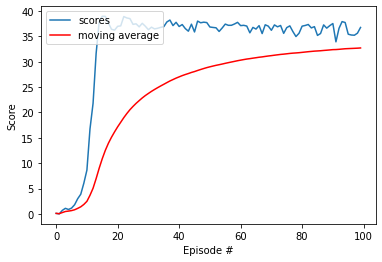

In [4]:
fig = plt.figure()
len_scores = len(trajectory_scores)

fig = plt.figure()
ax = fig.add_subplot(111)

plt.plot(np.arange(len_scores), trajectory_scores, label='scores')
plt.plot(np.arange(len_scores), moving_average_scores, c='r', label='moving average')

plt.ylabel('Score')
plt.xlabel('Episode #')

plt.legend(loc='upper left')

plt.show()

In [6]:
plt.savefig('scores_plot.png')

<Figure size 432x288 with 0 Axes>

In [ ]:
print('Closing the environment!')
env.close()